# Baseline models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM, Convolution1D, GlobalAveragePooling1D, Dense, Dropout
import keras_tuner as kt

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.9.2


In [2]:
train_data_df = pd.read_csv('../data_analysis/fd001/fd001-scaled_train.csv', sep=' ')
test_data_df = pd.read_csv('../data_analysis/fd001/fd001-scaled_test.csv', sep=' ')

train_labels_df = pd.read_csv('../data_analysis/fd001/fd001-training_labels.csv', sep=' ')
test_labels_df = pd.read_csv('../data_analysis/fd001/fd001-testing_labels.csv', sep=' ')
test_labels_at_break_df = pd.DataFrame(pd.read_csv('../TED/CMAPSSData/RUL_FD001.txt', sep=' ', header=None)[0])
test_labels_at_break_df.columns = ['RUL']

In [3]:
test_at_break_df = test_data_df.groupby(['ID'], sort=False).last().reset_index()

### Windows extraction

In [4]:
def get_windows(data_df, labels_df, window_length, mode = 'train'):

    if mode == 'train':

        labels_df['ID'] = data_df['ID']

        data_groupby = data_df.groupby('ID', sort=False)
        labels_groupby = labels_df.groupby('ID', sort=False)

        val_indices = np.random.choice(len(data_groupby), size = int(0.2 * len(data_groupby)))

        tr_data_eng_arr = []
        tr_labels_eng_arr = []

        val_data_eng_arr = []
        val_labels_eng_arr = []

        for i in range(len(data_groupby)):
            if i in val_indices:
                val_data_eng_arr.append(data_groupby.get_group(i+1))
            else:
                tr_data_eng_arr.append(data_groupby.get_group(i+1))

        for i in range(len(labels_groupby)):
            if i in val_indices:
                val_labels_eng_arr.append(labels_groupby.get_group(i+1))
            else:
                tr_labels_eng_arr.append(labels_groupby.get_group(i+1))

        tr_data_windows = []
        tr_label_windows = []
        for index in range(len(tr_data_eng_arr)):
            tr_data_arr = tr_data_eng_arr[index].to_numpy()
            tr_labels_arr = tr_labels_eng_arr[index].to_numpy()
            for t in range(tr_data_arr.shape[0] - window_length + 1):
                tr_data_windows.append(tr_data_arr[t:t+window_length, :])
                tr_label_windows.append(tr_labels_arr[t+window_length - 1, 0])

        val_data_windows = []
        val_label_windows = []
        for index in range(len(val_data_eng_arr)):
            val_data_arr = val_data_eng_arr[index].to_numpy()
            val_labels_arr = val_labels_eng_arr[index].to_numpy()
            for t in range(val_data_arr.shape[0] - window_length + 1):
                val_data_windows.append(val_data_arr[t:t+window_length, :])
                val_label_windows.append(val_labels_arr[t+window_length - 1, 0])

        return np.array(tr_data_windows), np.array(tr_label_windows), np.array(val_data_windows), np.array(val_label_windows)

    else:

        labels_df['ID'] = data_df['ID']

        data_groupby = data_df.groupby('ID', sort=False)
        labels_groupby = labels_df.groupby('ID', sort=False)
        data_eng_arr = []
        labels_eng_arr = []

        for i in range(len(data_groupby)):
            data_eng_arr.append(data_groupby.get_group(i+1))

        for i in range(len(labels_groupby)):
            labels_eng_arr.append(labels_groupby.get_group(i+1))

        data_windows = []
        label_windows = []
        for index in range(len(data_eng_arr)):
            data_arr = data_eng_arr[index].to_numpy()
            labels_arr = labels_eng_arr[index].to_numpy()
            data_windows.append(data_arr[-window_length:, :])
            label_windows.append(labels_arr[-1, 0])

        return np.array(data_windows), np.array(label_windows)

### Divide train set between train and validation sets

In [5]:
train_labels_df['ID'] = train_data_df['ID']

In [6]:
train_groupby_df = train_data_df.groupby(['ID'], sort = False)
train_labels_groupby_df = train_labels_df.groupby(['ID'], sort = False)
val_indices = np.random.choice(len(train_groupby_df), size = int(0.2 * len(train_groupby_df)))

val_arr = []
train_set_arr = []
val_labels_arr = []
train_set_labels_arr = []

for i in range(len(train_groupby_df)):
    if i in val_indices:
        val_arr.append(train_groupby_df.get_group(i+1))
        val_labels_arr.append(train_labels_groupby_df.get_group(i+1)['RUL'])
    else:
        train_set_arr.append(train_groupby_df.get_group(i+1))
        train_set_labels_arr.append(train_labels_groupby_df.get_group(i+1)['RUL'])

val_set_df = val_arr[0]
val_labels_df = val_labels_arr[0]
for i in range(1, len(val_arr)):
    val_set_df = pd.concat([val_set_df, val_arr[i]])
    val_labels_df = pd.concat([val_labels_df, val_labels_arr[i]])

train_set_df = train_set_arr[0]
train_set_labels_df = train_set_labels_arr[0]
for i in range(1, len(train_set_arr)):
    train_set_df = pd.concat([train_set_df, train_set_arr[i]])
    train_set_labels_df = pd.concat([train_set_labels_df, train_set_labels_arr[i]])

train_set = train_set_df.values
train_set_labels = train_set_labels_df.values
val_set = val_set_df.values
val_labels = val_labels_df.values
val_labels = np.expand_dims(val_labels, axis = 1)
train_set_labels = np.expand_dims(train_set_labels, axis = 1)
train_labels = np.expand_dims(train_labels_df.values, axis = 1)

## Random Forest Regressor

In [59]:
rf_param_grid = {
    'bootstrap': [True, False], 
    'max_depth': [6, 7, 8, 9, 10], 
    'min_samples_leaf': [30, 35, 40, 45, 50],
    'max_features': ['log2', 'sqrt'], 
    'n_estimators': [100 * x for x in range(5, 11)],
    }

In [60]:
rf = RandomForestRegressor(random_state=42)
rand_search_rf = RandomizedSearchCV(estimator = rf, param_distributions = rf_param_grid, cv = 3, n_jobs = 1, verbose = 3, return_train_score=True)
rand_search_rf.fit(train_data_full_df.values[:,1:], train_labels_full_df.values.squeeze())
rf_results = pd.DataFrame(rand_search_rf.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=35, n_estimators=900;, score=(train=0.695, test=0.777) total time=  10.4s
[CV 2/3] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=35, n_estimators=900;, score=(train=0.743, test=0.677) total time=  10.6s
[CV 3/3] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=35, n_estimators=900;, score=(train=0.756, test=0.636) total time=  10.3s
[CV 1/3] END bootstrap=True, max_depth=9, max_features=log2, min_samples_leaf=50, n_estimators=800;, score=(train=0.712, test=0.785) total time=   7.7s
[CV 2/3] END bootstrap=True, max_depth=9, max_features=log2, min_samples_leaf=50, n_estimators=800;, score=(train=0.760, test=0.679) total time=   7.6s
[CV 3/3] END bootstrap=True, max_depth=9, max_features=log2, min_samples_leaf=50, n_estimators=800;, score=(train=0.772, test=0.643) total time=   7.6s
[CV 1/3] END bootstrap=F

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [6, 7, 8, 9, 10],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [30, 35, 40, 45,
                                                             50],
                                        'n_estimators': [500, 600, 700, 800,
                                                         900, 1000]},
                   return_train_score=True, verbose=3)

In [68]:
predictions_rf = rand_search_rf.predict(test_at_break_df.values[:,1:]).round()
print(rand_search_rf.best_params_)
rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_rf))
print("RMSE: " + str(rmse)) 

NameError: name 'rand_search_rf' is not defined

## Gradient Boosting Regressor

In [66]:
gb_params = {
    'learning_rate': [0.001, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100 * x for x in range(5, 11)],
    'subsample': [0.75, 0.85, 0.95, 1],
    'min_samples_leaf': [30, 35, 40, 45, 50],
}

In [67]:
gb = GradientBoostingRegressor()
rand_search_gb = RandomizedSearchCV(estimator = gb, param_distributions = gb_params, cv = 3, n_jobs = 1, verbose = 3, return_train_score=True)
rand_search_gb.fit(train_data_full_df.values[:,1:], train_labels_full_df.values.squeeze())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END learning_rate=0.2, min_samples_leaf=30, n_estimators=700, subsample=0.75;, score=(train=0.829, test=0.730) total time=  19.3s
[CV 2/3] END learning_rate=0.2, min_samples_leaf=30, n_estimators=700, subsample=0.75;, score=(train=0.856, test=0.649) total time=  19.4s
[CV 3/3] END learning_rate=0.2, min_samples_leaf=30, n_estimators=700, subsample=0.75;, score=(train=0.867, test=0.601) total time=  19.4s
[CV 1/3] END learning_rate=0.2, min_samples_leaf=40, n_estimators=600, subsample=0.75;, score=(train=0.816, test=0.737) total time=  16.4s
[CV 2/3] END learning_rate=0.2, min_samples_leaf=40, n_estimators=600, subsample=0.75;, score=(train=0.845, test=0.652) total time=  16.5s
[CV 3/3] END learning_rate=0.2, min_samples_leaf=40, n_estimators=600, subsample=0.75;, score=(train=0.854, test=0.598) total time=  16.5s
[CV 1/3] END learning_rate=0.001, min_samples_leaf=40, n_estimators=1000, subsample=1;, score=(train=0.57

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=1,
                   param_distributions={'learning_rate': [0.001, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'min_samples_leaf': [30, 35, 40, 45,
                                                             50],
                                        'n_estimators': [500, 600, 700, 800,
                                                         900, 1000],
                                        'subsample': [0.75, 0.85, 0.95, 1]},
                   return_train_score=True, verbose=3)

In [69]:
predictions_gb = rand_search_gb.predict(test_at_break_df.values[:,1:]).round()
print(rand_search_gb.best_params_)
rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_gb))
print("RMSE: " + str(rmse)) 

{'subsample': 0.85, 'n_estimators': 500, 'min_samples_leaf': 30, 'learning_rate': 0.05}
RMSE: 31.969985924300936


## Support Vector Regressor

In [70]:
svmr_params = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [1, 2, 5, 10],
    'epsilon': [0.1 * i for i in range(1, 6)]
}

In [71]:
svmr = SVR()
rand_search_svmr = RandomizedSearchCV(estimator = svmr, param_distributions = svmr_params, cv = 3, n_jobs = 1, verbose = 3, return_train_score=True)
rand_search_svmr.fit(train_data_full_df.values[:,1:], train_labels_full_df.values.squeeze())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END C=1, epsilon=0.2, kernel=rbf;, score=(train=0.551, test=0.736) total time=  12.3s
[CV 2/3] END C=1, epsilon=0.2, kernel=rbf;, score=(train=0.586, test=0.618) total time=  12.3s
[CV 3/3] END C=1, epsilon=0.2, kernel=rbf;, score=(train=0.666, test=0.436) total time=  12.2s
[CV 1/3] END C=2, epsilon=0.2, kernel=poly;, score=(train=0.267, test=0.367) total time=   5.7s
[CV 2/3] END C=2, epsilon=0.2, kernel=poly;, score=(train=0.279, test=0.320) total time=   5.7s
[CV 3/3] END C=2, epsilon=0.2, kernel=poly;, score=(train=0.352, test=-0.336) total time=   5.7s
[CV 1/3] END C=1, epsilon=0.4, kernel=poly;, score=(train=0.259, test=0.350) total time=   5.6s
[CV 2/3] END C=1, epsilon=0.4, kernel=poly;, score=(train=0.274, test=0.313) total time=   5.6s
[CV 3/3] END C=1, epsilon=0.4, kernel=poly;, score=(train=0.345, test=-0.391) total time=   5.7s
[CV 1/3] END C=5, epsilon=0.4, kernel=linear;, score=(train=0.601, test=0.76

RandomizedSearchCV(cv=3, estimator=SVR(), n_jobs=1,
                   param_distributions={'C': [1, 2, 5, 10],
                                        'epsilon': [0.1, 0.2,
                                                    0.30000000000000004, 0.4,
                                                    0.5],
                                        'kernel': ['rbf', 'linear', 'poly']},
                   return_train_score=True, verbose=3)

In [72]:
predictions_svmr = rand_search_svmr.predict(test_at_break_df.values[:,1:]).round()
print(rand_search_svmr.best_params_)
rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_svmr))
print("RMSE: " + str(rmse)) 

{'kernel': 'rbf', 'epsilon': 0.4, 'C': 10}
RMSE: 33.32101439032131


## Multi Layer Perceptron - Neural Network

In [7]:
window_length = 20
mlp_tr_data, mlp_tr_labels, mlp_val_data, mlp_val_labels = get_windows(train_data_df, train_labels_df, window_length, mode='train')
mlp_test_data, mlp_test_labels = get_windows(test_data_df, test_labels_df, 20, mode = 'test')

mlp_tr_data = mlp_tr_data.reshape(mlp_tr_data.shape[0], -1)
mlp_val_data = mlp_val_data.reshape(mlp_val_data.shape[0], -1)
mlp_test_data = mlp_test_data.reshape(mlp_test_data.shape[0], -1)

mlp_tr_labels = np.expand_dims(mlp_tr_labels, axis=1)
mlp_val_labels = np.expand_dims(mlp_val_labels, axis=1)
mlp_test_labels = np.expand_dims(mlp_test_labels, axis=1)

In [9]:
def mlp_model_builder(hp):

    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=128, step=32)
    hp_units3 = hp.Int('units3', min_value=32, max_value=128, step=32)

    hp_dropout = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3, 0.4])
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01, 0.05])

    mlp_model = Sequential()
    mlp_model.add(Dense(units = hp_units1, activation = 'relu', input_dim = mlp_tr_data.shape[1]))
    mlp_model.add(Dropout(hp_dropout))
    mlp_model.add(Dense(units = hp_units2, activation = 'relu'))
    mlp_model.add(Dropout(hp_dropout))
    mlp_model.add(Dense(units = hp_units3 , activation = 'relu'))
    mlp_model.add(Dropout(hp_dropout))
    mlp_model.add(Dense(1, activation = 'relu'))

    mlp_model.compile(optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss=keras.losses.MeanSquaredError())

    return mlp_model

mlp_tuner = kt.BayesianOptimization(mlp_model_builder,
                                    objective='val_loss',
                                    max_trials = 9,
                                    directory='baseline_models',
                                    project_name='mlp')

INFO:tensorflow:Reloading Oracle from existing project baseline_models/mlp/oracle.json
Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-07-27 11:57:50.834824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-27 11:57:50.834965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
mlp_tuner.search(mlp_tr_data, mlp_tr_labels, epochs=100, validation_data = (mlp_val_data, mlp_val_labels), batch_size = 128)
best_mlp_hps = mlp_tuner.get_best_hyperparameters(num_trials=1)[0]

best_mlp_model = mlp_tuner.hypermodel.build(best_mlp_hps)
mlp_history = best_mlp_model.fit(mlp_tr_data, mlp_tr_labels, epochs=100, validation_data = (mlp_val_data, mlp_val_labels), batch_size = 128)

Trial 2 Complete [00h 01m 25s]
val_loss: 1560.2862548828125

Best val_loss So Far: 1560.2862548828125
Total elapsed time: 00h 02m 52s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |128               |units1
64                |128               |units2
32                |64                |units3
0.4               |0.4               |dropout_rate
0.001             |0.05              |learning_rate

Epoch 1/100
  1/123 [..............................] - ETA: 39s - loss: 11998.3828

2022-07-27 12:00:48.255836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - 2s 12ms/step - loss: 4706.2905 - val_loss: 1661.2532
Epoch 2/100
  1/123 [..............................] - ETA: 0s - loss: 3184.5486

2022-07-27 12:00:49.769932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - 1s 7ms/step - loss: 2315.0576 - val_loss: 1500.6592
Epoch 3/100
123/123 [==============================] - 1s 7ms/step - loss: 1895.9395 - val_loss: 918.3068
Epoch 4/100
123/123 [==============================] - 1s 7ms/step - loss: 1723.7787 - val_loss: 1198.5342
Epoch 5/100
123/123 [==============================] - 1s 7ms/step - loss: 1588.9470 - val_loss: 1603.9802
Epoch 6/100
123/123 [==============================] - 1s 7ms/step - loss: 1500.2236 - val_loss: 1584.6609
Epoch 7/100
123/123 [==============================] - 1s 7ms/step - loss: 1397.9941 - val_loss: 1911.3866
Epoch 8/100
123/123 [==============================] - 1s 7ms/step - loss: 1359.5338 - val_loss: 1500.7694
Epoch 9/100
123/123 [==============================] - 1s 7ms/step - loss: 1298.6401 - val_loss: 1612.0178
Epoch 10/100
123/123 [==============================] - 1s 7ms/step - loss: 1294.6243 - val_loss: 1447.3007
Epoch 11/100
123/123 [===========================

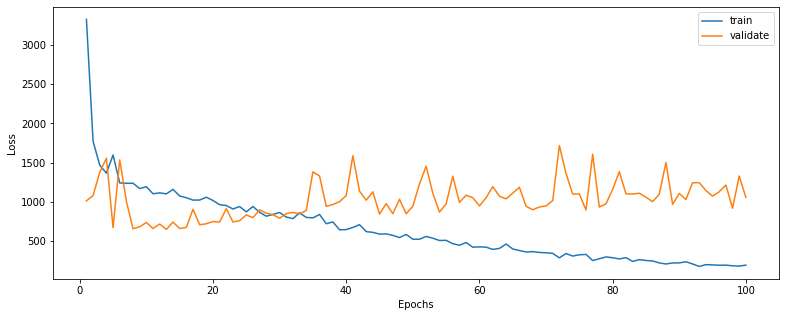

In [50]:
# PLOT TRAIN AND VALIDATION LOSS
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(mlp_history)

In [51]:
# TESTING FUNCTION
def testing(actual, pred, mode = 'Test'):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(mode + ' set RMSE: ' + str(rmse) + ', R2: ' + str(variance))

In [52]:
train_full_pred = best_mlp_model.predict(mlp_tr_data)
testing(mlp_tr_labels, train_full_pred, 'Train')

test_at_break_pred = best_mlp_model.predict(mlp_test_data)
testing(mlp_test_labels, test_at_break_pred)

 72/482 [===>..........................] - ETA: 0s

2022-07-27 00:18:23.356019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


482/482 [==============================] - 1s 2ms/step
Train set RMSE: 15.37380002321018, R2: 0.945183824869444
4/4 [==============================] - 0s 2ms/step
Test set RMSE: 40.9208608875001, R2: 0.030316559064948678


## Convolutional Neural Network

In [135]:
window_length = 20
cnn_tr_data, cnn_tr_labels, cnn_val_data, cnn_val_labels = get_windows(train_data_df, train_labels_df, window_length, mode='train')
cnn_test_data, cnn_test_labels = get_windows(test_data_df, test_labels_df, 20, mode = 'test')

cnn_tr_labels = np.expand_dims(cnn_tr_labels, axis=1)
cnn_val_labels = np.expand_dims(cnn_val_labels, axis=1)
cnn_test_labels = np.expand_dims(cnn_test_labels, axis=1)

### Model

In [136]:
cnn_model = Sequential()
cnn_model.add(Convolution1D(256, 3, input_shape = (window_length, cnn_tr_data.shape[2])))
cnn_model.add(Convolution1D(128, 3, activation = 'relu'))
cnn_model.add(Convolution1D(64, 3, activation = 'relu'))
cnn_model.add(GlobalAveragePooling1D(data_format = 'channels_last', keepdims = False))
cnn_model.add(Dense(1, activation = 'relu'))

cnn_model.compile(loss='mean_squared_error', optimizer='adam')
cnn_model.save_weights('simple_lstm_weights.h5')

cnn_model.compile(loss='mean_squared_error', optimizer='adam')  
cnn_model.load_weights('simple_lstm_weights.h5')  

history = cnn_model.fit(cnn_tr_data, cnn_tr_labels,
                        validation_data=(cnn_val_data, cnn_val_labels),
                        epochs=50,
                        batch_size=128)

Epoch 1/50
  8/122 [>.............................] - ETA: 0s - loss: 7681.7368 

2022-07-26 17:33:09.632991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 1s 8ms/step - loss: 3332.7180 - val_loss: 1900.2971
Epoch 2/50
 11/122 [=>............................] - ETA: 0s - loss: 2050.6697

2022-07-26 17:33:10.634091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 1s 6ms/step - loss: 1871.3906 - val_loss: 1652.0077
Epoch 3/50
122/122 [==============================] - 1s 6ms/step - loss: 1703.9670 - val_loss: 1946.6705
Epoch 4/50
122/122 [==============================] - 1s 6ms/step - loss: 1555.0143 - val_loss: 1713.3628
Epoch 5/50
122/122 [==============================] - 1s 6ms/step - loss: 1406.7285 - val_loss: 1894.7319
Epoch 6/50
122/122 [==============================] - 1s 6ms/step - loss: 1317.6168 - val_loss: 1691.8712
Epoch 7/50
122/122 [==============================] - 1s 6ms/step - loss: 1272.6362 - val_loss: 1867.6289
Epoch 8/50
122/122 [==============================] - 1s 6ms/step - loss: 1171.1572 - val_loss: 2243.1619
Epoch 9/50
122/122 [==============================] - 1s 6ms/step - loss: 1163.7954 - val_loss: 1526.9408
Epoch 10/50
122/122 [==============================] - 1s 6ms/step - loss: 1160.9053 - val_loss: 1536.1240
Epoch 11/50
122/122 [==============================] - 1

In [137]:
# TESTING FUNCTION
def evaluate(actual, pred, mode = 'test'):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(mode + ' set RMSE: ' + str(rmse) + ', R2: ' + str(variance))

In [138]:
# TESTING
train_cnn_pred = cnn_model.predict(cnn_tr_data)
evaluate(cnn_tr_labels, train_cnn_pred, 'train')

test_cnn_pred = cnn_model.predict(cnn_test_data)
evaluate(cnn_test_labels, test_cnn_pred)

 88/485 [====>.........................] - ETA: 0s

2022-07-26 17:33:52.158932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


485/485 [==============================] - 1s 2ms/step
train set RMSE: 23.811225368314084, R2: 0.8667401887967089
4/4 [==============================] - 0s 7ms/step
test set RMSE: 43.661987771604466, R2: -0.10394506693947148


## LSTM Neural Network

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, activation='tanh', input_shape=(window_length, cnn_tr_data.shape[2])))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.save_weights('simple_lstm_weights.h5')

lstm_model.compile(loss='mean_squared_error', optimizer='adam')  
lstm_model.load_weights('simple_lstm_weights.h5')  

history = lstm_model.fit(cnn_tr_data, cnn_tr_labels,
                        validation_data=(cnn_val_data, cnn_val_labels),
                        epochs=50,
                        batch_size=128)

In [ ]:
# PLOT LOSS HISTORY
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:
# TESTING FUNCTION
def evaluate(actual, pred, mode = 'test'):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(mode + ' set RMSE: ' + str(rmse) + ', R2: ' + str(variance))

In [ ]:
# TESTING
train_cnn_pred = lstm_model.predict(cnn_tr_data)
evaluate(cnn_tr_labels, train_cnn_pred, 'train')

test_cnn_pred = lstm_model.predict(cnn_test_data)
evaluate(cnn_test_labels, test_cnn_pred)